In [37]:
import gc # сборщик мусора
import datetime # для работы со времнем
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from lightgbm import LGBMRegressor

import pickle

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# клакстеризация
from sklearn.cluster import KMeans

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [38]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(10,10))
    
    #sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    plt.scatter(pred_values, true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [39]:
def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [40]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df.median()

        self.roomsquare_median = df['Square'].median()/df['Rooms'].median()
        self.ls_s_median = df['LifeSquare'].median()/df['Square'].median()
        self.ks_s_median = df['KitchenSquare'].median()/df['Square'].median()
        
    def transform(self, df):
        """Трансформация данных"""

        
        #Неправильные годы
        # Исправляем на очевидные
        df.loc[df['HouseYear'] == 20052011,'HouseYear'] = 2011
        df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
        # остальные 
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        #df['HouseYear_outlier'] = 0
        #df.loc[df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        df.loc[df['HouseYear'] > current_year, 'HouseYear'] = current_year        
        
        #по медиане
        #df.loc[(df['HouseYear'] > 2020) | (df['HouseYear'] < 1900), 'HouseYear'] = self.medians['HouseYear']
        
       # Убираем 0  и выбросы в Rooms
        #Сначала вычислим количество комнат из расчета медианнй площади одной комнаты и на эту величину поделим общую площадь
        df.loc[(df['Rooms']< 1) | (df['Rooms'] > 6),'Rooms'] = round(df['Square']/self.roomsquare_median)
        # Если округление = 0 то поставим 1
        df.loc[df['Rooms']< 1,'Rooms'] = 1
        
        # Исправим маленькую площадь (< 12)
        #Исправим площадь общую
        df.loc[df['Square'] < 12, 'Square'] = df['Rooms'] * self.roomsquare_median
        
        
        # LifeSquare
        df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1
        
        condition = (df['LifeSquare'].isna()) &\
                      (~df['Square'].isna()) & \
                      (~df['KitchenSquare'].isna())
        
        df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] * self.ls_s_median
               
        
        
        # Исправим жилую площадь LifeSquare. Сначала удалим все значения где LifeSquare > общей площади
        #df.loc[df['LifeSquare']>df['Square'],'LifeSquare']  = np.nan
        
        #Заполняем пропущенные LifeSquare через Square * коэф (средняя жилая на среднюю общую площадь)
        #df.loc[df['LifeSquare'].isnull(),'LifeSquare'] = df['Square'] * self.ls_s_median

        
        
        # HouseFloor, Floor
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        #X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        #X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']

        

        
        # Убираем 0 в HouseFloor
        df.loc[df['HouseFloor']<1, 'HouseFloor'] = df['Floor']
        #Исправляем этажность дома где он меньше чем этаж квартиры
        df.loc[(df['HouseFloor']<df['Floor']), 'HouseFloor'] = df['Floor']
 
        # Убираем выбросы в KitchenSquare
        df.loc[(df['KitchenSquare'] < 1) | (df['KitchenSquare'] > 30 ), 'KitchenSquare' ] = df['Square'] * self.ks_s_median

        # 1. Пропуски
        
        # Исправим пропуски 'Healthcare_1'
        df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = 0
        
    
        # 2. Выбросы (outliers)

        # Кухня больше чем треть квартиры
        #df.loc[df['KitchenSquare'] > (df['Square']/3), 'KitchenSquare' ] = df['Square'] * self.ks_s_median
        
        # 3. Новые фичи (features)
        
        # Относительная высота квартиры в доме
        df['h_relative'] = df['Floor']/df['HouseFloor']
        # Многоэтажный дом
        # df['mkd'] = df['HouseFloor'].apply(lambda x: 1 if x > 2 else 0)

        # 1 этаж = 0, последний этаж = 2 , остальные = 1
        #df['cat_floor'] = 1
        #df.loc[(df['Floor'] == df['HouseFloor']), 'cat_floor'] = 2
        #df.loc[df['Floor'] < 3, 'cat_floor'] = 0
        
        df['DistrictId'] = df['DistrictId'].astype(str)
        
        # Обработка категорий
        df['Ec_2'] = df['Ecology_2'].apply(lambda x: 1 if x == 'A' else 0)
        df['Ec_3'] = df['Ecology_3'].apply(lambda x: 1 if x == 'A' else 0)
        df['Sh_2'] = df['Shops_2'].apply(lambda x: 1 if x == 'A' else 0)
        df = df.drop(['Ecology_2','Ecology_3','Shops_2'], axis=1)
        return df

      
        

## Читаем файлы

In [41]:
df = pd.read_csv('train.csv')
X_final = pd.read_csv('test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

df.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  df.shape[0])
print('Строк в тесте', X_final.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


----

# 2 Очистка данных

In [42]:

pipe = DataPipeline()
pipe.fit(df) # расчет статистик
df = pipe.transform(df)
X_final = pipe.transform(X_final)
print('Строк в трейне:' ,  df.shape[0])
print('Строк в тесте', X_final.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [43]:
X_final.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_nan,HouseFloor_outlier,h_relative,Ec_2,Ec_3,Sh_2
Id,,,,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,11,...,1,0.0,0,0,0,0,0.428571,0,0,0
15856,74,2.0,69.263183,43.237313,1.0,6,6.0,1977,0.075779,6,...,3,0.0,0,2,1,1,1.000000,0,0,0
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,30,...,87,4702.0,5,5,0,0,0.400000,0,0,0
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,23,...,3,0.0,3,3,0,0,1.000000,0,0,0
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,2,...,1,0.0,0,0,0,0,1.000000,0,0,1


In [44]:
df.dtypes

DistrictId             object
Rooms                 float64
Square                float64
LifeSquare            float64
KitchenSquare         float64
Floor                   int64
HouseFloor            float64
HouseYear               int64
Ecology_1             float64
Social_1                int64
Social_2                int64
Social_3                int64
Healthcare_1          float64
Helthcare_2             int64
Shops_1                 int64
Price                 float64
LifeSquare_nan          int32
HouseFloor_outlier      int64
h_relative            float64
Ec_2                    int64
Ec_3                    int64
Sh_2                    int64
dtype: object

In [45]:
X_final.dtypes

DistrictId             object
Rooms                 float64
Square                float64
LifeSquare            float64
KitchenSquare         float64
Floor                   int64
HouseFloor            float64
HouseYear               int64
Ecology_1             float64
Social_1                int64
Social_2                int64
Social_3                int64
Healthcare_1          float64
Helthcare_2             int64
Shops_1                 int64
LifeSquare_nan          int32
HouseFloor_outlier      int64
h_relative            float64
Ec_2                    int64
Ec_3                    int64
Sh_2                    int64
dtype: object

In [46]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Healthcare_1,Helthcare_2,Shops_1,Price,LifeSquare_nan,HouseFloor_outlier,h_relative,Ec_2,Ec_3,Sh_2
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.88970,56.355970,37.300075,6.187105,8.526700,13.435700,1984.866300,0.118858,24.687000,5352.157400,...,594.538900,1.319500,4.231300,214138.857399,0.211300,0.182500,0.664910,0.009700,0.027500,0.082500
std,0.81523,21.001419,76.868952,3.685943,5.241148,6.094012,18.412271,0.119025,17.532614,4006.799803,...,932.112976,1.493601,4.806341,92872.293865,0.408251,0.386275,0.290145,0.098015,0.163543,0.275139
min,1.00000,13.784865,0.370619,1.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000
25%,1.00000,41.782323,24.352570,3.509849,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,0.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.411765,0.000000,0.000000,0.000000
50%,2.00000,52.529412,33.290490,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,...,30.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.687500,0.000000,0.000000,0.000000
75%,2.00000,65.912854,44.933550,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,...,990.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,8.00000,641.065193,7480.592129,30.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


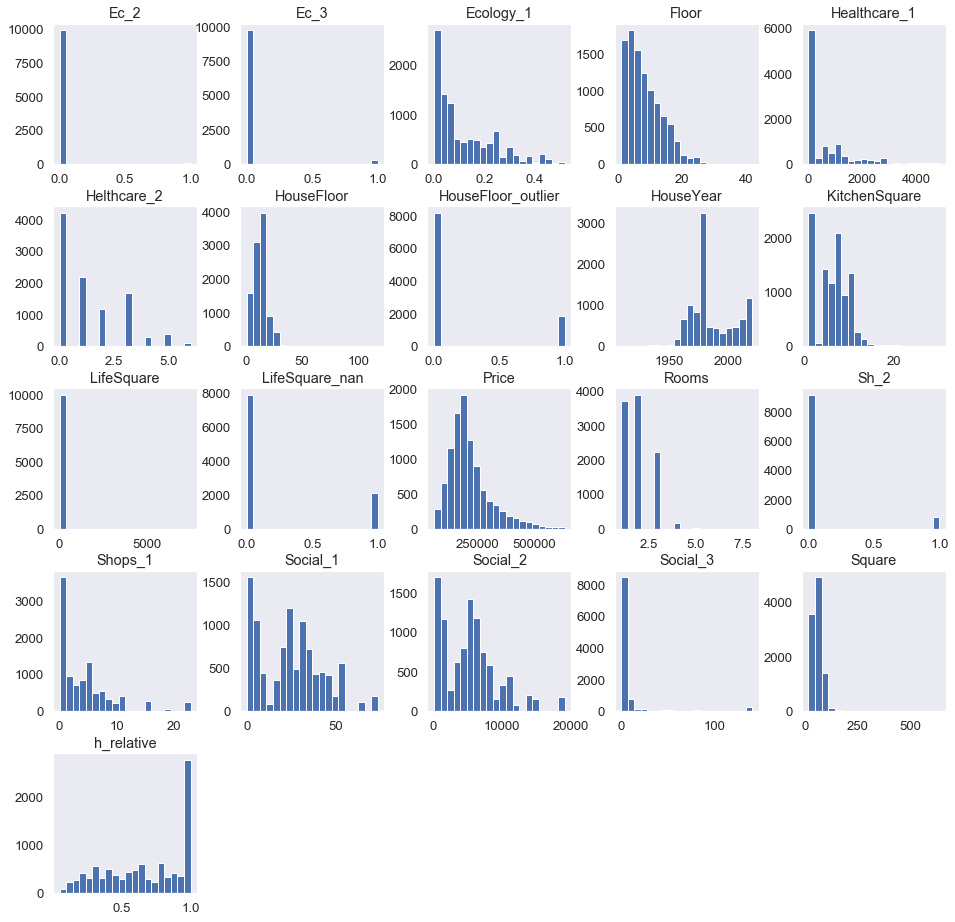

In [47]:
df.hist(figsize=(16,16), bins=20, grid=False);

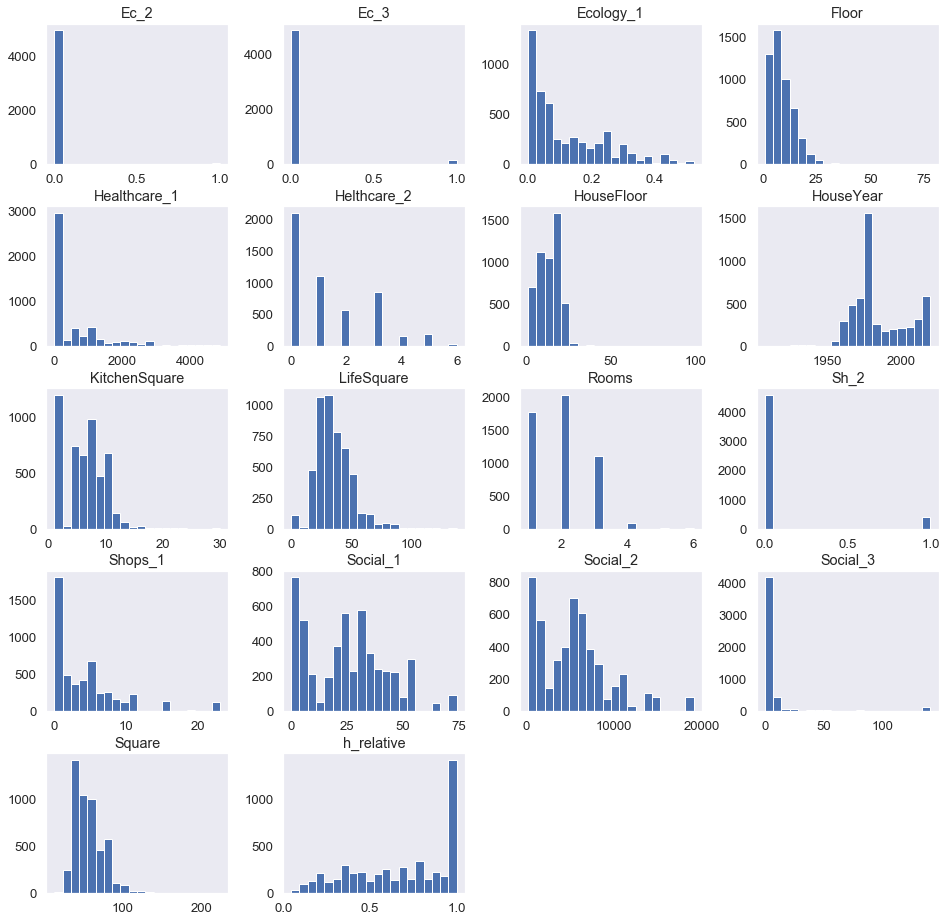

In [141]:
X_final.hist(figsize=(16,16), bins=20, grid=False);

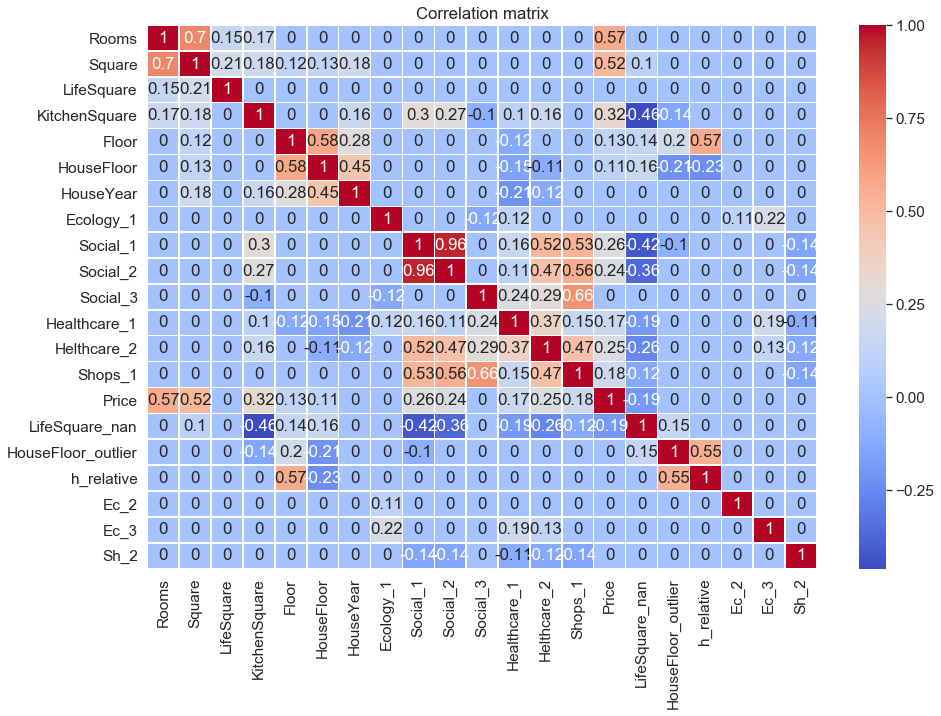

In [49]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [51]:
df['HouseYear'].median()

1977.0

-------------------------

In [52]:
df.isnull().sum()

DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Price                 0
LifeSquare_nan        0
HouseFloor_outlier    0
h_relative            0
Ec_2                  0
Ec_3                  0
Sh_2                  0
dtype: int64

In [53]:
X_final.isnull().sum()



DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
LifeSquare_nan        0
HouseFloor_outlier    0
h_relative            0
Ec_2                  0
Ec_3                  0
Sh_2                  0
dtype: int64

------

In [54]:
df.shape

(10000, 22)

In [55]:
X_final.shape

(5000, 21)

# 3. Feature engineering

In [56]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец flooar_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1952, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1952) & (X['HouseYear'] <= 1974), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1974) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
            
    

In [57]:
X = df.drop(['Price'], axis=1)
y = df[['Price']]

In [58]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,LifeSquare_nan,HouseFloor_outlier,h_relative,Ec_2,Ec_3,Sh_2
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.000000,7,9.0,1969,0.089040,33,...,0.0,0,11,184966.930730,0,0,0.777778,0,0,0
15053,41,3.0,65.683640,40.049543,8.000000,7,9.0,1978,0.000070,46,...,240.0,1,16,300009.450063,0,0,0.777778,0,0,0
4765,53,2.0,44.947953,29.197612,5.135607,8,12.0,1968,0.049637,34,...,229.0,1,3,220925.908524,0,0,0.666667,0,0,0
5809,58,2.0,53.352981,52.731512,9.000000,8,17.0,1977,0.437885,23,...,1084.0,0,5,175616.227217,0,0,0.470588,0,0,0
10783,99,1.0,39.649192,23.776169,7.000000,11,12.0,1976,0.012339,35,...,2078.0,2,4,150226.531644,0,0,0.916667,0,0,0


In [59]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)


In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 27 columns):
DistrictId             10000 non-null object
Rooms                  10000 non-null float64
Square                 10000 non-null float64
LifeSquare             10000 non-null float64
KitchenSquare          10000 non-null float64
Floor                  10000 non-null int64
HouseFloor             10000 non-null float64
HouseYear              10000 non-null int64
Ecology_1              10000 non-null float64
Social_1               10000 non-null int64
Social_2               10000 non-null int64
Social_3               10000 non-null int64
Healthcare_1           10000 non-null float64
Helthcare_2            10000 non-null int64
Shops_1                10000 non-null int64
LifeSquare_nan         10000 non-null int32
HouseFloor_outlier     10000 non-null int64
h_relative             10000 non-null float64
Ec_2                   10000 non-null int64
Ec_3                   10000 non-null i

In [61]:
df1 = X.copy()
df1['Price'] = y.values
df1.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ec_2,Ec_3,Sh_2,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,Price
0,35,2.0,47.981561,29.442751,6.000000,7,9.0,1969,0.089040,33,...,0,0,0,5.0,1,3.0,2.0,NaN,186977.474076,184966.930730
1,41,3.0,65.683640,40.049543,8.000000,7,9.0,1978,0.000070,46,...,0,0,0,87.0,0,3.0,3.0,300009.450063,173714.223985,300009.450063
2,53,2.0,44.947953,29.197612,5.135607,8,12.0,1968,0.049637,34,...,0,0,0,174.0,0,3.0,2.0,263206.223152,186977.474076,220925.908524
3,58,2.0,53.352981,52.731512,9.000000,8,17.0,1977,0.437885,23,...,0,0,0,179.0,0,3.0,3.0,166809.665642,173714.223985,175616.227217
4,99,1.0,39.649192,23.776169,7.000000,11,12.0,1976,0.012339,35,...,0,0,0,97.0,0,4.0,3.0,158539.052715,178342.566861,150226.531644


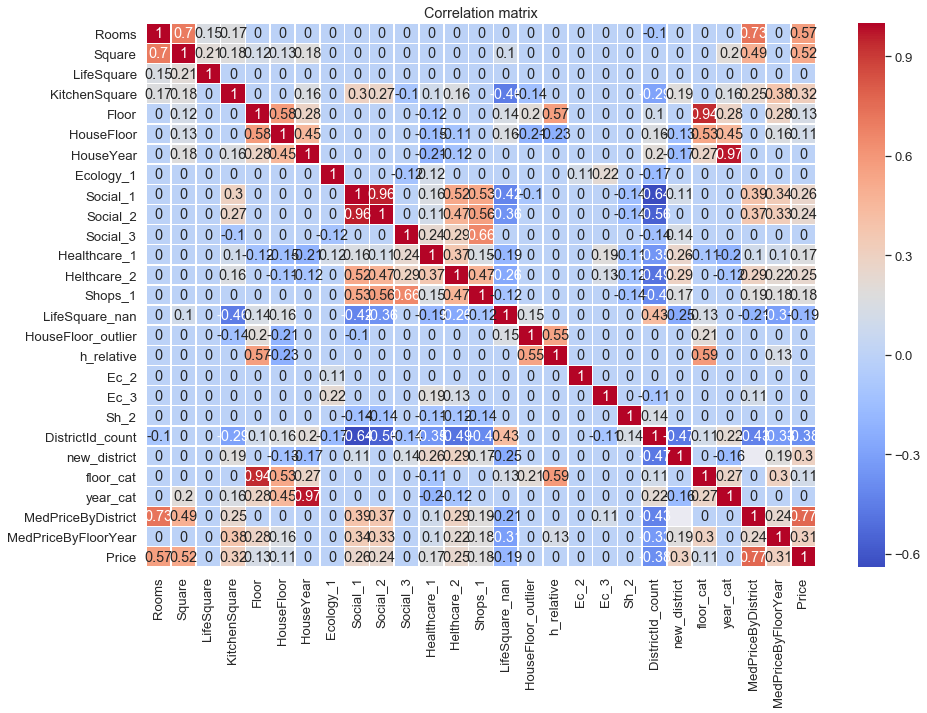

In [62]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.2)

corr_matrix = df1.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [63]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                   #'HouseFloor_outlier', 
                   'HouseFloor', 'HouseYear', 'DistrictId_count', 
                   #'LifeSquare_nan', 
                   #'Ec_2', 'Ec_3', 'Sh_2',
                   'MedPriceByDistrict', 'MedPriceByFloorYear', 'Social_2', 'Social_3',
                   #'Healthcare_1',
                   'Helthcare_2'#, 'h_relative', 
                   #'new_district', 'floor_cat', 'year_cat'
                  ]
X = X[remain_features]
X_final = X_final[remain_features]

In [64]:
X.index = df.index

In [65]:
X.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Shops_1,HouseFloor,HouseYear,DistrictId_count,MedPriceByDistrict,MedPriceByFloorYear,Social_2,Social_3,Helthcare_2
Id,,,,,,,,,,,,,,,,
14038,2.0,47.981561,29.442751,6.000000,7,0.089040,33,11,9.0,1969,5.0,NaN,186977.474076,7976,5,0
15053,3.0,65.683640,40.049543,8.000000,7,0.000070,46,16,9.0,1978,87.0,300009.450063,173714.223985,10309,1,1
4765,2.0,44.947953,29.197612,5.135607,8,0.049637,34,3,12.0,1968,174.0,263206.223152,186977.474076,7759,0,1
5809,2.0,53.352981,52.731512,9.000000,8,0.437885,23,5,17.0,1977,179.0,166809.665642,173714.223985,5735,3,0
10783,1.0,39.649192,23.776169,7.000000,11,0.012339,35,4,12.0,1976,97.0,158539.052715,178342.566861,5776,1,2


# 4. Модель

In [76]:
model = LGBMRegressor(max_depth=10,
                             min_samples_leaf=7,
                             n_estimators=150,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.746 +- 0.016


In [77]:
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=7,
              min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [78]:
feature_importances = pd.DataFrame(zip(X.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,613
11,MedPriceByDistrict,424
9,HouseYear,420
2,LifeSquare,402
5,Ecology_1,349
3,KitchenSquare,343
8,HouseFloor,287
14,Social_3,271
13,Social_2,264
4,Floor,263


In [79]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions_9.csv', index=False)

preds_final.head()

,Id,Price
0,725,152973.726488
1,15856,230994.811842
2,5480,200687.850869
3,15664,316110.595587
4,14275,147888.874743


In [70]:
lgb_model = LGBMRegressor(criterion='mse',
                            #min_samples_leaf=10,
                            random_state=42 #,
                         
                         # n_estimators=100,
                         # max_depth=7
                         
                         )

In [71]:
params = {'n_estimators':[50, 100, 150, 200, 250, 300, 400], 
          'max_depth':[5, 7, 10, 15, 20, 30],
          'min_samples_leaf': [7,10,30]}

gs = GridSearchCV(lgb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
#gs.fit(X_train, y_train)  # НА TRAIN!
gs.fit(X, y)  # НА TRAIN!

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, criterion='mse',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10, 15, 20, 30],
                         'min_sampl

In [72]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.167949,0.002863,0.018751,0.001164,5,7,50,"{'max_depth': 5, 'min_samples_leaf': 7, 'n_est...",0.728694,0.706022,0.736511,0.750538,0.721620,0.728677,0.014848,124
1,0.272072,0.009062,0.031517,0.005661,5,7,100,"{'max_depth': 5, 'min_samples_leaf': 7, 'n_est...",0.744626,0.716351,0.744901,0.764122,0.727908,0.739582,0.016321,97


In [73]:
gs.best_params_

{'max_depth': 10, 'min_samples_leaf': 7, 'n_estimators': 150}

In [74]:
gs.best_score_

0.747412420258151

-----

# Reduce и кластеризация (проверка)

## Разбивка трейна

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Shops_1,HouseFloor,HouseYear,DistrictId_count,MedPriceByDistrict,MedPriceByFloorYear,Social_2,Social_3,Helthcare_2
Id,,,,,,,,,,,,,,,,
12473,1.0,65.271225,62.798045,1.0,3,0.437885,23,5,3.0,1977,179.0,122600.506993,164755.432571,5735,3,0
14050,2.0,45.091598,43.816601,1.0,5,0.236108,16,10,18.0,2017,5.0,NaN,155380.494351,3893,27,3
3779,1.0,34.463114,20.561823,5.0,3,0.150818,16,5,5.0,1960,5.0,NaN,183046.534725,3433,4,4
3762,3.0,61.931107,46.126389,5.0,4,0.265089,37,2,5.0,1966,72.0,330243.499560,183046.534725,5288,0,3
358,1.0,42.670840,26.637131,1.0,8,0.007122,1,1,17.0,1977,652.0,146735.671740,173714.223985,264,0,0


In [85]:
id_train = X_train.index
id_test = X_test.index
print(id_train, id_test)

Int64Index([12473, 14050,  3779,  3762,   358,  6519,  6076, 12584,  4144,
            15303,
            ...
            10278, 10587,  2086,  4718,  9708, 10013,  6431, 14239,  5487,
             2135],
           dtype='int64', name='Id', length=8000) Int64Index([ 3702, 12848,  2239, 15611,  5634, 14726,  7247,  2018, 14587,
             3643,
            ...
             3428, 16239,  6142, 12594,  1451,   762, 10903, 13212,  3924,
             7409],
           dtype='int64', name='Id', length=2000)


In [86]:
X_test.shape

(2000, 16)

In [87]:
X1_train = X_train.drop(['MedPriceByDistrict','MedPriceByFloorYear'], axis=1)
X1_test = X_test.drop(['MedPriceByDistrict','MedPriceByFloorYear'], axis=1)
X1_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 12473 to 2135
Data columns (total 14 columns):
Rooms               8000 non-null float64
Square              8000 non-null float64
LifeSquare          8000 non-null float64
KitchenSquare       8000 non-null float64
Floor               8000 non-null int64
Ecology_1           8000 non-null float64
Social_1            8000 non-null int64
Shops_1             8000 non-null int64
HouseFloor          8000 non-null float64
HouseYear           8000 non-null int64
DistrictId_count    8000 non-null float64
Social_2            8000 non-null int64
Social_3            8000 non-null int64
Helthcare_2         8000 non-null int64
dtypes: float64(7), int64(7)
memory usage: 937.5 KB


## Модель

In [88]:
model = LGBMRegressor(max_depth=15,
                             min_samples_leaf=7,
                             n_estimators=150,
                             random_state=42)
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=7,
              min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [89]:
y_pred_test = model.predict(X_test)
print('R2 test:', r2_score(y_test, y_pred_test))

R2 test: 0.7277216844923569


In [90]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,657
11,MedPriceByDistrict,445
2,LifeSquare,419
9,HouseYear,414
5,Ecology_1,351
14,Social_3,279
4,Floor,270
8,HouseFloor,264
3,KitchenSquare,253
13,Social_2,244


In [91]:
X_train.shape, X_final.shape

((8000, 16), (5000, 16))

R2:	0.728
RMSE:	48878.429
MSE:	2389100793.492


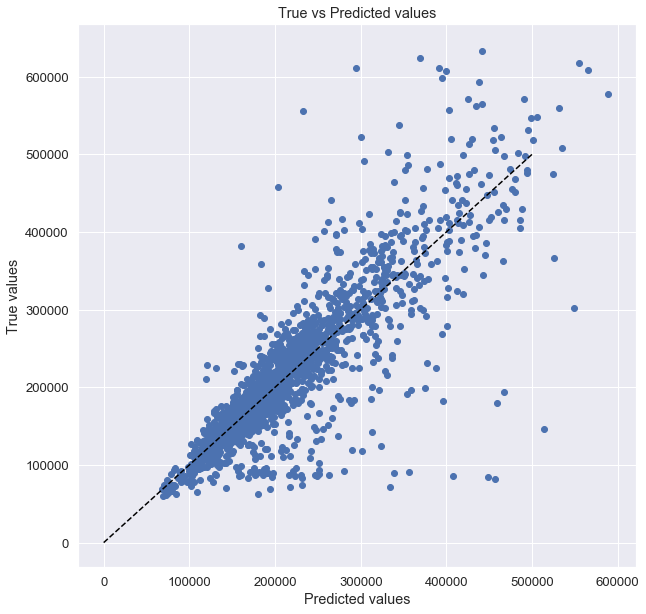

In [92]:
evaluate_preds(y_test, y_pred_test)

R2:	0.501
RMSE:	66192.022
MSE:	4381383781.41


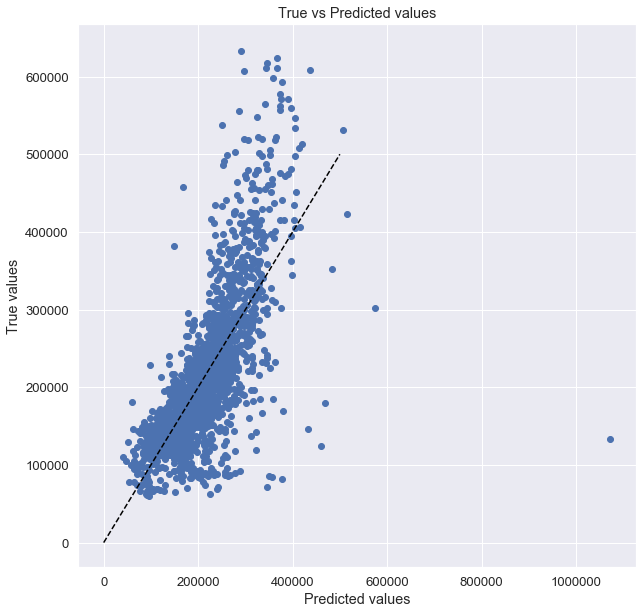

In [94]:
lr_model = LinearRegression()
lr_model.fit(X1_train, y_train)

y_train_preds = lr_model.predict(X1_test)
# Постпрецессинг
#y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_train_preds)

In [96]:
X1_train.isnull().sum()

Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
Ecology_1           0
Social_1            0
Shops_1             0
HouseFloor          0
HouseYear           0
DistrictId_count    0
Social_2            0
Social_3            0
Helthcare_2         0
dtype: int64

In [97]:
X1_test.isnull().sum()

Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
Ecology_1           0
Social_1            0
Shops_1             0
HouseFloor          0
HouseYear           0
DistrictId_count    0
Social_2            0
Social_3            0
Helthcare_2         0
dtype: int64

# Масштабирование

In [100]:
#scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
scaler = StandardScaler()
colnames = X1_train.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X1_train), columns=colnames, index = id_train )
X_test_scaled = pd.DataFrame(scaler.transform(X1_test), columns=X1_test.columns, index = id_test) # НЕ обучаемся на тесте!

X_train_scaled.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Shops_1,HouseFloor,HouseYear,DistrictId_count,Social_2,Social_3,Helthcare_2
Id,,,,,,,,,,,,,,
12473,-1.093630,0.441393,0.298308,-1.403171,-1.051995,2.707529,-0.098199,0.156818,-1.705911,-0.433147,-0.212693,0.093759,-0.211080,-0.881893
14050,0.138456,-0.550712,0.075532,-1.403171,-0.668920,1.000902,-0.495739,1.197246,0.742970,1.744772,-0.850595,-0.364835,0.800788,1.132519
3779,-1.093630,-1.073247,-0.197398,-0.318089,-1.051995,0.279512,-0.495739,0.156818,-1.379393,-1.358763,-0.850595,-0.479359,-0.168919,1.803989
3762,1.370541,0.277181,0.102641,-0.318089,-0.860458,1.246016,0.696880,-0.467438,-1.379393,-1.032075,-0.604966,-0.017528,-0.337563,1.132519
358,-1.093630,-0.669725,-0.126095,-1.403171,-0.094308,-0.935861,-1.347609,-0.675523,0.579711,-0.433147,1.521373,-1.268329,-0.337563,-0.881893


In [101]:
X_test_scaled.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Shops_1,HouseFloor,HouseYear,DistrictId_count,Social_2,Social_3,Helthcare_2
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.012783,0.015432,-0.004746,0.019685,0.032873,0.045971,-0.011962,-0.015684,-0.010959,-0.024216,0.005497,-0.007777,0.006893,0.020564
std,1.021918,1.153385,0.263036,0.999282,1.018814,1.032332,0.978248,1.000550,0.974175,1.012265,1.004969,0.987675,1.023662,1.014299
min,-1.093630,-1.954058,-0.422238,-1.403171,-1.435070,-0.996102,-1.404400,-0.883609,-2.032428,-4.081161,-0.850595,-1.292229,-0.337563,-0.881893
25%,-1.093630,-0.708749,-0.156195,-0.546363,-0.860458,-0.831097,-1.063652,-0.675523,-0.726358,-0.650939,-0.663623,-0.944674,-0.337563,-0.881893
50%,0.138456,-0.196305,-0.049499,-0.046819,-0.094308,-0.355166,0.015383,-0.259353,0.089935,-0.433147,-0.476652,-0.018275,-0.253241,-0.210422
75%,0.138456,0.468739,0.094329,0.766992,0.671841,0.696738,0.583297,0.156818,0.579711,0.873604,1.004453,0.424882,-0.158378,0.461048
max,7.530966,28.749549,7.051083,6.192401,5.460275,3.417846,2.798160,3.902357,5.640731,1.908115,2.250927,3.416944,5.607157,3.146931


# Reduce

In [102]:
dim_reducer = PCA(n_components = 3, random_state=42)
components_train = pd.DataFrame(data = dim_reducer.fit_transform(X_train_scaled), columns = ['com1','com2','com3'], index = X_train.index )
components_test = pd.DataFrame(data = dim_reducer.transform(X_test_scaled), columns = ['com1','com2','com3'], index = X_test.index)
components_train.head()

,com1,com2,com3
Id,,,
12473,-0.278571,-2.089145,0.743158
14050,0.629931,0.161198,-1.037532
3779,0.784785,-2.790903,0.138675
3762,1.083725,-1.129859,2.151176
358,-2.877065,-0.944001,-1.008400


-----

In [100]:
X_train_scaled = pd.concat([X_train_scaled, components_train, c_12_train], axis=1)
X_test_scaled = pd.concat([X_test_scaled, components_test, c_12_test], axis=1)

In [62]:
X_train_scaled.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Shops_1,HouseFloor_outlier,HouseFloor,...,Ec_3,Sh_2,Social_2,Social_3,Healthcare_1,Helthcare_2,h_relative,new_district,floor_cat,year_cat
Id,,,,,,,,,,,,,,,,,,,,,
12473,-1.093630,0.441393,0.298308,-1.403171,-1.051995,2.707529,-0.098199,0.156818,2.137090,-1.705911,...,-0.170114,-0.3011,0.093759,-0.211080,0.531808,-0.881893,1.163628,-0.556366,-0.914765,-0.400095
14050,0.138456,-0.550712,0.075532,-1.403171,-0.668920,1.000902,-0.495739,1.197246,-0.467926,0.742970,...,-0.170114,-0.3011,-0.364835,0.800788,-0.632942,1.132519,-1.325100,1.797377,-0.914765,1.737071
3779,-1.093630,-1.073247,-0.197398,-0.318089,-1.051995,0.279512,-0.495739,0.156818,-0.467926,-1.379393,...,-0.170114,-0.3011,-0.479359,-0.168919,2.206942,1.803989,-0.214745,1.797377,-0.914765,-1.112484
3762,1.370541,0.277181,0.102641,-0.318089,-0.860458,1.246016,0.696880,-0.467438,-0.467926,-1.379393,...,-0.170114,-0.3011,-0.017528,-0.337563,1.448350,1.132519,0.474442,-0.556366,-0.914765,-1.112484
358,-1.093630,-0.669725,-0.126095,-1.403171,-0.094308,-0.935861,-1.347609,-0.675523,-0.467926,0.579711,...,-0.170114,-0.3011,-1.268329,-0.337563,-0.632942,-0.881893,-0.660689,-0.556366,-0.038448,-0.400095


In [104]:
X_train_scaled = pd.concat([X_train_scaled, pd.get_dummies(X_train_scaled['clusters_12'], drop_first=True, prefix='cl_12')], axis=1)
X_test_scaled = pd.concat([X_test_scaled, pd.get_dummies(X_test_scaled['clusters_12'], drop_first=True, prefix='cl_12')], axis=1)

In [117]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 12473 to 2135
Data columns (total 32 columns):
DistrictId       8000 non-null float64
Rooms            8000 non-null float64
Square           8000 non-null float64
LifeSquare       8000 non-null float64
KitchenSquare    8000 non-null float64
Floor            8000 non-null float64
HouseFloor       8000 non-null float64
HouseYear        8000 non-null float64
Ecology_1        8000 non-null float64
Social_1         8000 non-null float64
Social_2         8000 non-null float64
Social_3         8000 non-null float64
Healthcare_1     8000 non-null float64
Helthcare_2      8000 non-null float64
Shops_1          8000 non-null float64
Ec_2             8000 non-null float64
Ec_3             8000 non-null float64
Sh_2             8000 non-null float64
com1             8000 non-null float64
com2             8000 non-null float64
com3             8000 non-null float64
clusters_12      8000 non-null int32
cl_12_1          8000 non-null ui

In [118]:
X_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 3702 to 7409
Data columns (total 32 columns):
DistrictId       2000 non-null float64
Rooms            2000 non-null float64
Square           2000 non-null float64
LifeSquare       2000 non-null float64
KitchenSquare    2000 non-null float64
Floor            2000 non-null float64
HouseFloor       2000 non-null float64
HouseYear        2000 non-null float64
Ecology_1        2000 non-null float64
Social_1         2000 non-null float64
Social_2         2000 non-null float64
Social_3         2000 non-null float64
Healthcare_1     2000 non-null float64
Helthcare_2      2000 non-null float64
Shops_1          2000 non-null float64
Ec_2             2000 non-null float64
Ec_3             2000 non-null float64
Sh_2             2000 non-null float64
com1             2000 non-null float64
com2             2000 non-null float64
com3             2000 non-null float64
clusters_12      2000 non-null int32
cl_12_1          2000 non-null uin

In [108]:
X_train_scaled = X_train_scaled.drop('cl_12_2', axis=1)

In [110]:
model = LGBMRegressor(max_depth=30,
                             min_samples_leaf=10,
                             n_estimators=300,
                             random_state=42)
model.fit(X_train_scaled, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=30,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [111]:
y_pred_test = model.predict(X_test_scaled)
print('R2 test:', r2_score(y_test, y_pred_test))

R2 test: 0.7370596780011038


In [162]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                
                                n_estimators=100  # кол-во деревьев
                                )

rf_model.fit(X_train, y_train)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=30, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [163]:
y_pred_test = rf_model.predict(X_test)
print('R2 test:', r2_score(y_test, y_pred_test))

R2 test: 0.6730510094275081


In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 12473 to 2135
Data columns (total 26 columns):
Rooms                  8000 non-null float64
Square                 8000 non-null float64
LifeSquare             8000 non-null float64
KitchenSquare          8000 non-null float64
Floor                  8000 non-null int64
Ecology_1              8000 non-null float64
Social_1               8000 non-null int64
Shops_1                8000 non-null int64
HouseFloor_outlier     8000 non-null int64
HouseFloor             8000 non-null float64
HouseYear              8000 non-null int64
DistrictId_count       8000 non-null float64
LifeSquare_nan         8000 non-null int32
Ec_2                   8000 non-null int64
Ec_3                   8000 non-null int64
Sh_2                   8000 non-null int64
MedPriceByDistrict     6109 non-null float64
MedPriceByFloorYear    7998 non-null float64
Social_2               8000 non-null int64
Social_3               8000 non-null int64
Healthcare_

## Кластеризация

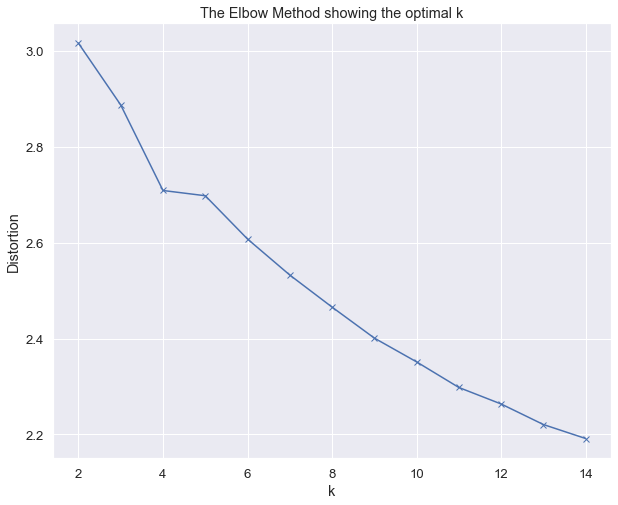

In [103]:
apply_elbow_method(X_train_scaled)

In [104]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Cluгsters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

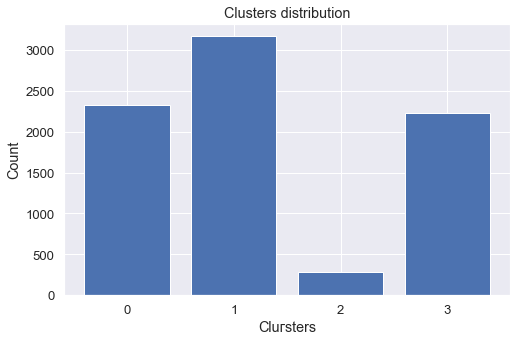

In [106]:
kmeans_s5 = KMeans(n_clusters=4, random_state=42)
s5_tr = kmeans_s5.fit_predict(X_train_scaled)
s5_train = pd.Series(s5_tr, name='clusters_s5',  index = X_train.index)

unique, counts = np.unique(s5_train, return_counts=True)
display_clusters_distribution(unique, counts)

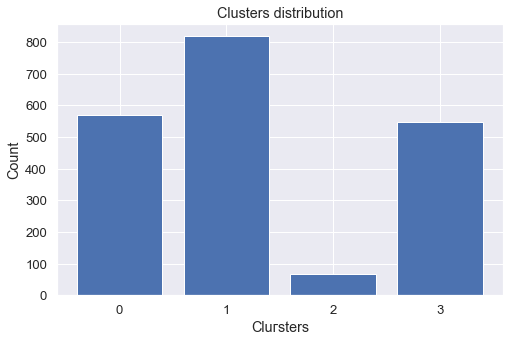

In [107]:
s5_t = kmeans_s5.predict(X_test_scaled)
s5_test = pd.Series(s5_t, name='clusters_s5',  index = X_test.index)
unique, counts = np.unique(s5_test, return_counts=True)
display_clusters_distribution(unique, counts)

In [108]:
s5_train.count(),s5_test.count() 

(8000, 2000)

In [82]:
X_train = pd.concat([X_train, components_train, s5_train], axis=1)
X_test = pd.concat([X_test, components_test, s5_test], axis=1)

In [83]:
X_final = pd.concat([X_final, components_final, s5_final], axis=1)

In [109]:
X_train1 = pd.concat([X_train, components_train, s5_train], axis=1)
X_test1 = pd.concat([X_test, components_test, s5_test], axis=1)


In [111]:
X_train1.shape

(8000, 20)

In [123]:
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 12473 to 2135
Data columns (total 24 columns):
Rooms                  8000 non-null float64
Square                 8000 non-null float64
LifeSquare             8000 non-null float64
KitchenSquare          8000 non-null float64
Floor                  8000 non-null int64
Ecology_1              8000 non-null float64
Social_1               8000 non-null int64
Shops_1                8000 non-null int64
HouseFloor             8000 non-null float64
HouseYear              8000 non-null int64
DistrictId_count       8000 non-null float64
MedPriceByDistrict     6109 non-null float64
MedPriceByFloorYear    7998 non-null float64
Social_2               8000 non-null int64
Social_3               8000 non-null int64
Helthcare_2            8000 non-null int64
com1                   8000 non-null float64
com2                   8000 non-null float64
com3                   8000 non-null float64
clusters_s5            8000 non-null int32
cl_s5

In [114]:
X_train1 = pd.concat([X_train1, pd.get_dummies(X_train1['clusters_s5'], prefix='cl_s5')], axis=1)
X_test1 = pd.concat([X_test1, pd.get_dummies(X_test1['clusters_s5'], prefix='cl_s5')], axis=1)

In [118]:
X_train2 = X_train1.drop(['clusters_s5' ], axis=1)
X_test2 = X_test1.drop(['clusters_s5' ], axis=1)


In [119]:
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 12473 to 2135
Data columns (total 23 columns):
Rooms                  8000 non-null float64
Square                 8000 non-null float64
LifeSquare             8000 non-null float64
KitchenSquare          8000 non-null float64
Floor                  8000 non-null int64
Ecology_1              8000 non-null float64
Social_1               8000 non-null int64
Shops_1                8000 non-null int64
HouseFloor             8000 non-null float64
HouseYear              8000 non-null int64
DistrictId_count       8000 non-null float64
MedPriceByDistrict     6109 non-null float64
MedPriceByFloorYear    7998 non-null float64
Social_2               8000 non-null int64
Social_3               8000 non-null int64
Helthcare_2            8000 non-null int64
com1                   8000 non-null float64
com2                   8000 non-null float64
com3                   8000 non-null float64
cl_s5_0                8000 non-null uint8
cl_s5

In [124]:
X_train2.shape, X_test2.shape

((8000, 23), (2000, 23))

In [125]:
model = LGBMRegressor(max_depth=15,
                             min_samples_leaf=7,
                             n_estimators=150,
                             random_state=42)
model.fit(X_train2, y_train)
y_pred_test = model.predict(X_test2)
print('R2 test:', r2_score(y_test, y_pred_test))

R2 test: 0.7197791941863589


In [127]:
feature_importances = pd.DataFrame(zip(X_train2.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,512
11,MedPriceByDistrict,352
9,HouseYear,341
17,com2,317
2,LifeSquare,314
5,Ecology_1,311
16,com1,302
18,com3,298
14,Social_3,224
3,KitchenSquare,207


R2:	0.72
RMSE:	49586.208
MSE:	2458792020.489


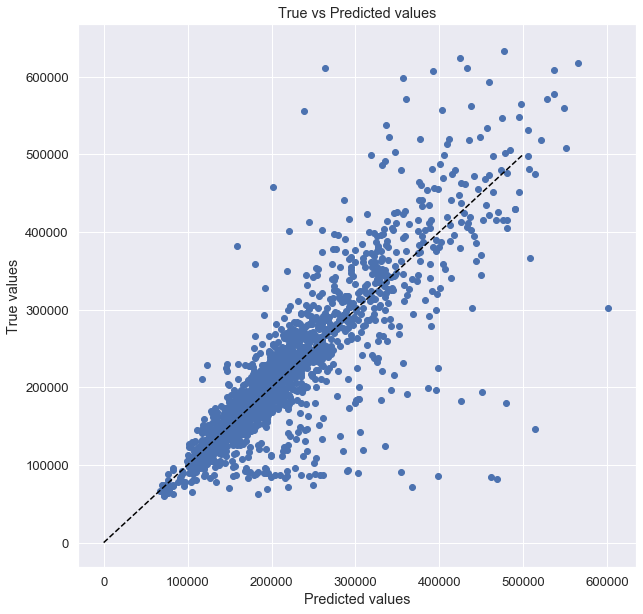

In [128]:
evaluate_preds(y_test, y_pred_test)

In [129]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                
                                n_estimators=100  # кол-во деревьев
                                )

In [131]:
X_train3 = X_train2.drop(['MedPriceByDistrict', 'MedPriceByFloorYear'], axis=1)
X_test3 = X_test2.drop(['MedPriceByDistrict', 'MedPriceByFloorYear'], axis=1)

In [132]:
rf_model.fit(X_train3, y_train)
y_pred_test = rf_model.predict(X_test3)
print('R2 test:', r2_score(y_test, y_pred_test))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


R2 test: 0.6884837024578165


In [133]:
lr = LinearRegression()
lr.fit(X_train3, y_train)
y_pred_test = lr.predict(X_test3)
print('R2 test:', r2_score(y_test, y_pred_test))

R2 test: 0.5196831900052006


# с кластеризацией и reduce получилось хуже